# Mauritania country profile

In [2]:
import os, sys, glob, json
os.chdir('../gscd/notebook/')
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [3]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:3243' # Mauritania
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/MR_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Mauritania',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1990	 | MR1990A1 | 13	| MR1990A2	| 45	| nan	| 0	|
----------------------------------------------- #


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(',')[0])

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([MR_Admin1_1990, MR_Admin2_1990], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 3,960
Removed 1,298 "Missing Value" points
0/990 "Area Harvested" points are retained.
878/990 "Area Planted" points are retained.
948/990 "Quantity Produced" points are retained.
836/990 "Yield" points are retained.
Current data points: 2,662

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1989 - 2017
5 grain types are found: Maize (Corn), Millet, Rice (Paddy), Sorghum, Wheat Grain
7 seasons are found: Annual (06-01), Dam retention (10-01), Bas-fond (10-01), Main (06-01), Walo (11-01), Hot off-season (03-01), Cold off-season (11-01)
7 crop production system are found: none, dam irrigation, surface water, dieri, parastatal recessional , flood recessional , irrigated
Data sources include:
[1] Ministry of Rural Development, Mauritania --- FEWS NET Agro Maps, Mauritania
[2] Ministry of Rural Development, Mauritania --- Official Agricultural Statistics,

## Mauritania
Mauritania crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-mauritania.png?itok=fcsQC56T)

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_mr_calendar.png)

- comparison of boundaries
![image](../figures/MR_admin_shapes.png)

- FDW data consists of `MR1990A1`.

- FEWS NET admin shapefiles ------------------- #

| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  | :---:  | :---:  |
| 1990	 | MR1990A1 | 13	| MR1990A2	| 45	| nan	| 0	|

- **`MR1990A1`** is used to represent the current admin-level 1 crop data.
- Mauritania has seven crop seasons: `Annual`, `Dam retention`, `Bas-fond`, `Main`, `Walo`, `Hot off-season`, `Cold off-season`.
- Mauritania has seven crop production systems: `none`, `dam irrigation`, `surface water`, `dieri`, `flood recessional` , `parastatal recessional` , `irrigated`.


In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = MR_Admin1_1990.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Link admin boundaries ------------------------- #
link, over = FDW_PD_CreateAdminLink(MR_Admin1_1990, MR_Admin1_1990, 'ADMIN1', 'ADMIN1', prod, epsg)
# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link, prod, over, mdx_pss)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'MR1990A108' as no record found in: ['MR1990A108']
CBR is considered for 'MR1990A113' as no record found in: ['MR1990A113']
CBR is considered for 'MR1990A111' as no record found in: ['MR1990A111']


In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #

# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #

# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of planting and Harvest year and season
cs = {
    'Annual': {'planting_month':{'06-01':'06-01'},'harvest_month':{'05-01':'05-01'}},
    'Dam retention': {'planting_month':{'10-01':'10-01'},'harvest_month':{'03-01':'03-01'}},
    'Bas-fond': {'planting_month':{'10-01':'10-01'},'harvest_month':{'03-01':'03-01'}},
    'Main': {'planting_month':{'06-01':'06-01'},'harvest_month':{'11-01':'11-01'}},
    'Walo ': {'planting_month':{'11-01':'11-01'},'harvest_month':{'04-01':'04-01'}},
    'Hot off-season': {'planting_month':{'03-01':'03-01'},'harvest_month':{'06-01':'06-01'}},
    'Cold off-season ': {'planting_month':{'11-01':'11-01'},'harvest_month':{'02-01':'02-01'}},
}
cy = {}
# cy = {'Deyr': {'planting_year':-1}}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

########################################################################

# Save data
save_hdf('../data/crop/adm_crop_production_MR.hdf', stack)
save_hdf('../data/crop/adm_crop_production_MR_raw.hdf', df)
save_npz('../data/crop/adm_crop_production_MR_ratio.npz', link_ratio)

../data/crop/adm_crop_production_MR.hdf is saved.
../data/crop/adm_crop_production_MR_raw.hdf is saved.
../data/crop/adm_crop_production_MR_ratio.npz is saved.


../figures/MR_bar_natgrainprod_Annual.png is saved.


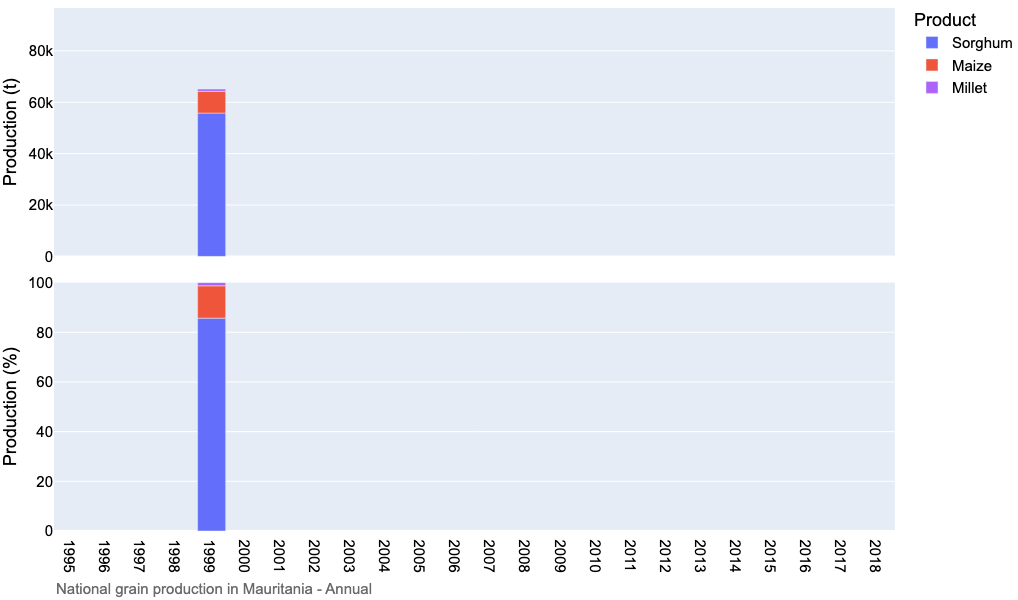

../figures/MR_bar_natgrainprod_Dam retention.png is saved.


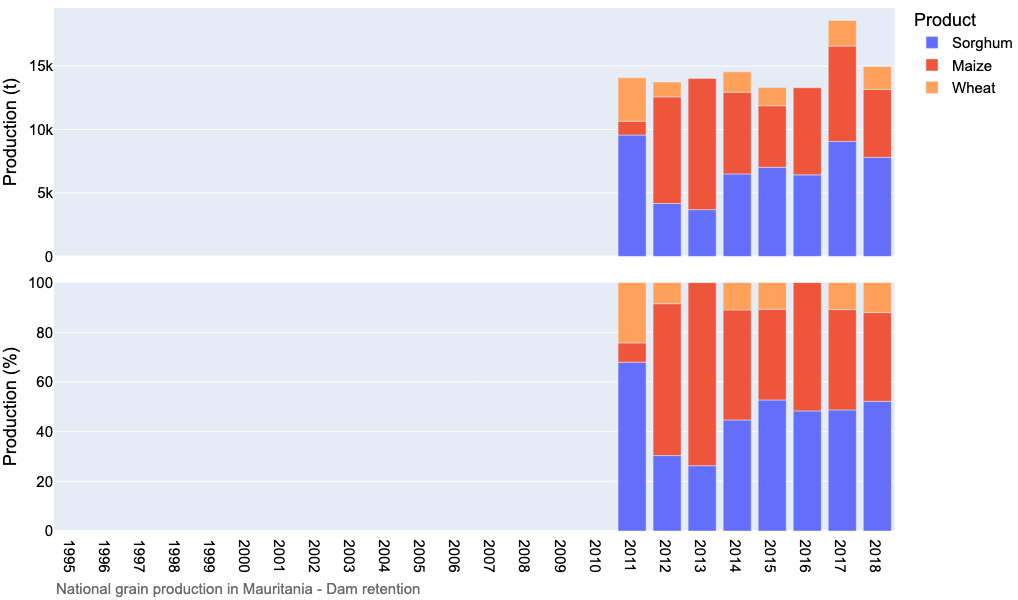

../figures/MR_bar_natgrainprod_Bas-fond.png is saved.


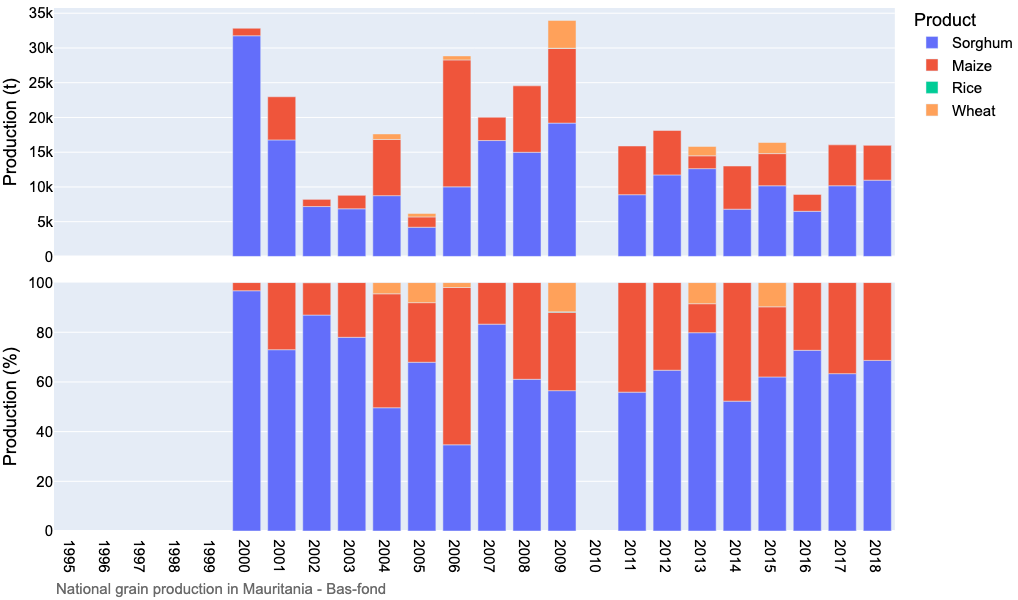

../figures/MR_bar_natgrainprod_Main.png is saved.


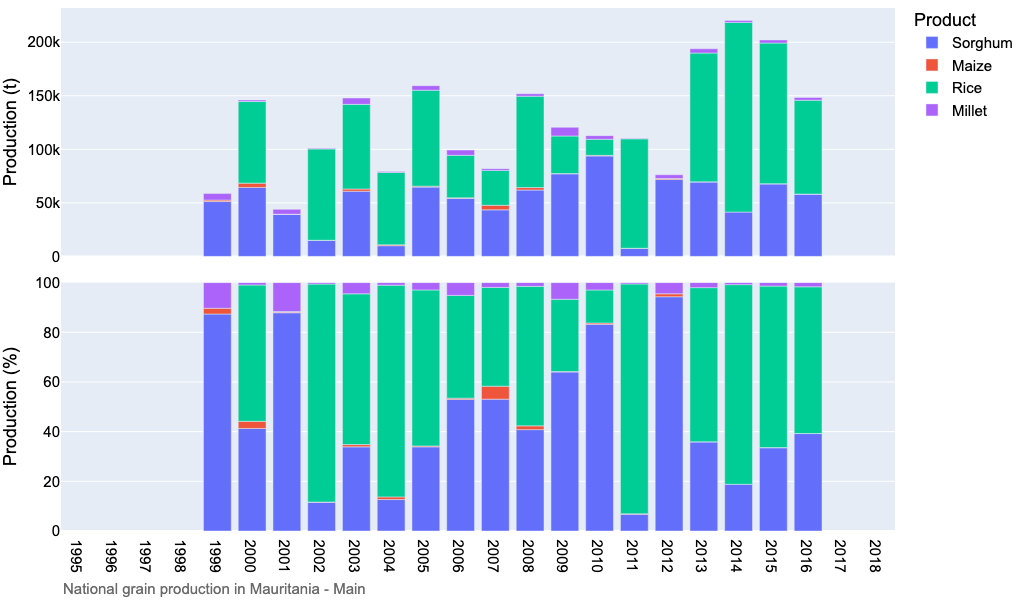

../figures/MR_bar_natgrainprod_Walo.png is saved.


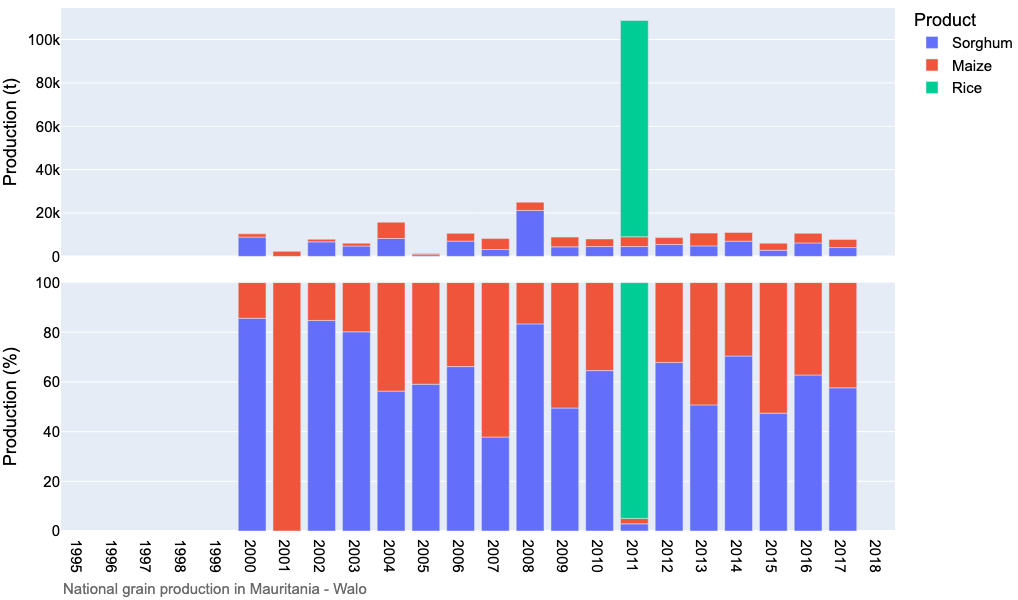

../figures/MR_bar_natgrainprod_Hot off-season.png is saved.


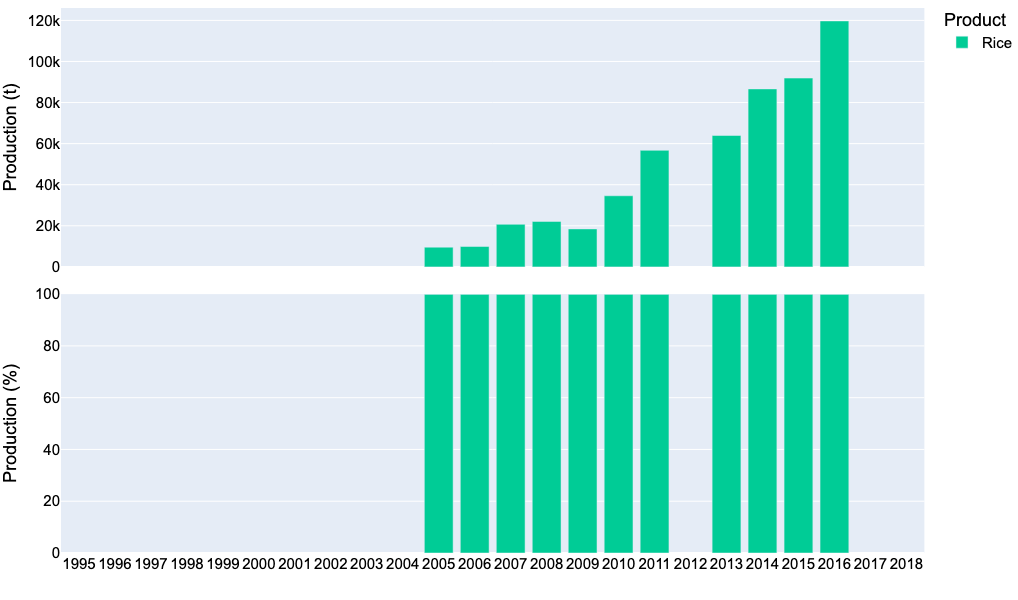

../figures/MR_bar_natgrainprod_Cold off-season.png is saved.


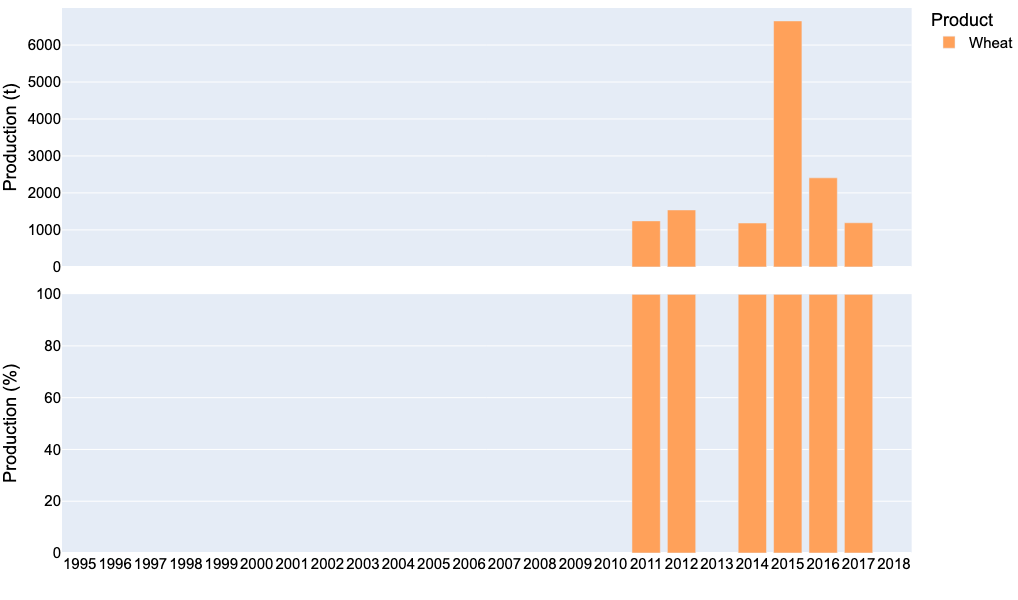

In [8]:
# Bar chart of national grain production
country_iso, country_name = 'MR', 'Mauritania'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [1995, df['year'].max()]
product_order = ['Sorghum','Maize','Rice','Millet','Wheat']
for season_name in ['Annual', 'Dam retention', 'Bas-fond', 'Main', 'Walo', 'Hot off-season', 'Cold off-season']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()


../figures/MR_line_pay_Maize_Main.png is saved.


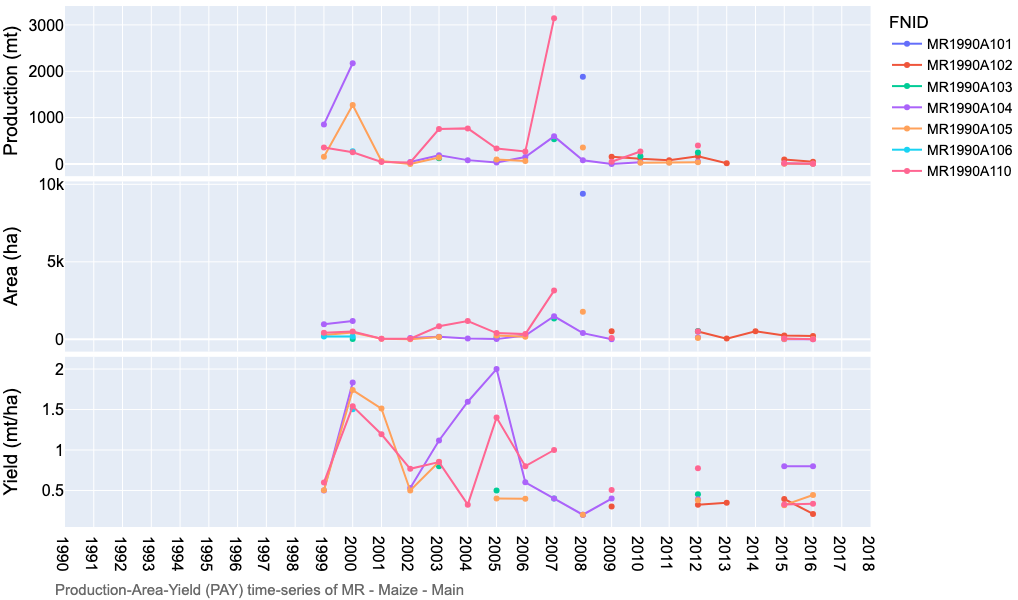

../figures/MR_line_pay_Maize_Annual.png is saved.


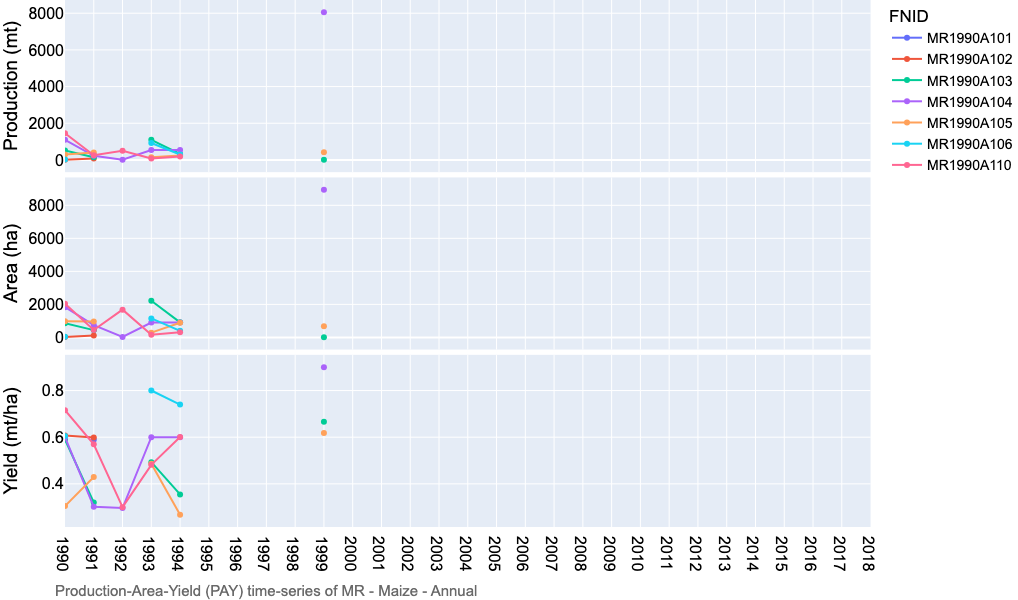

../figures/MR_line_pay_Maize_Bas-fond.png is saved.


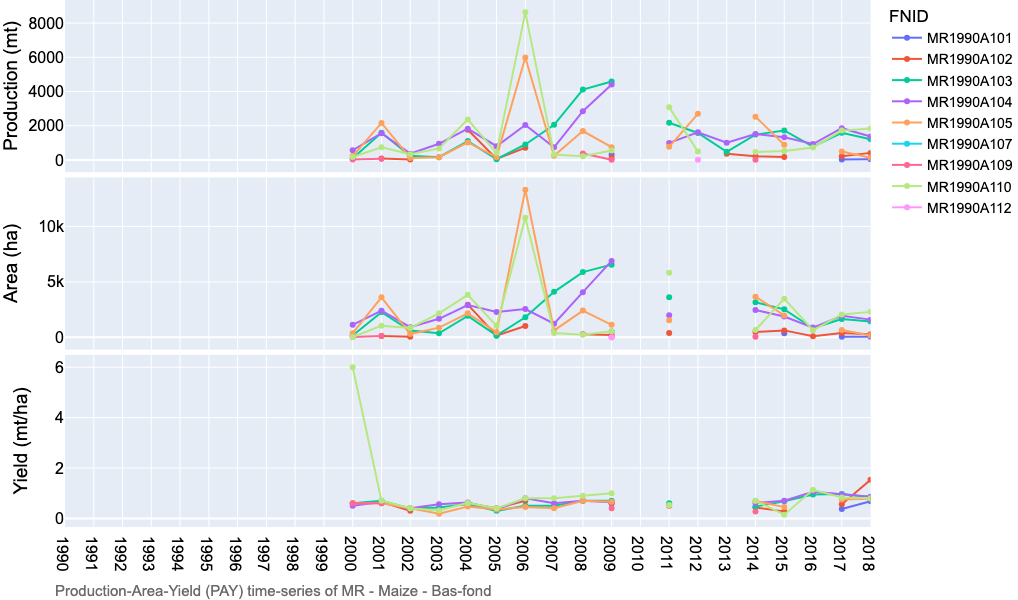

../figures/MR_line_pay_Maize_Dam retention.png is saved.


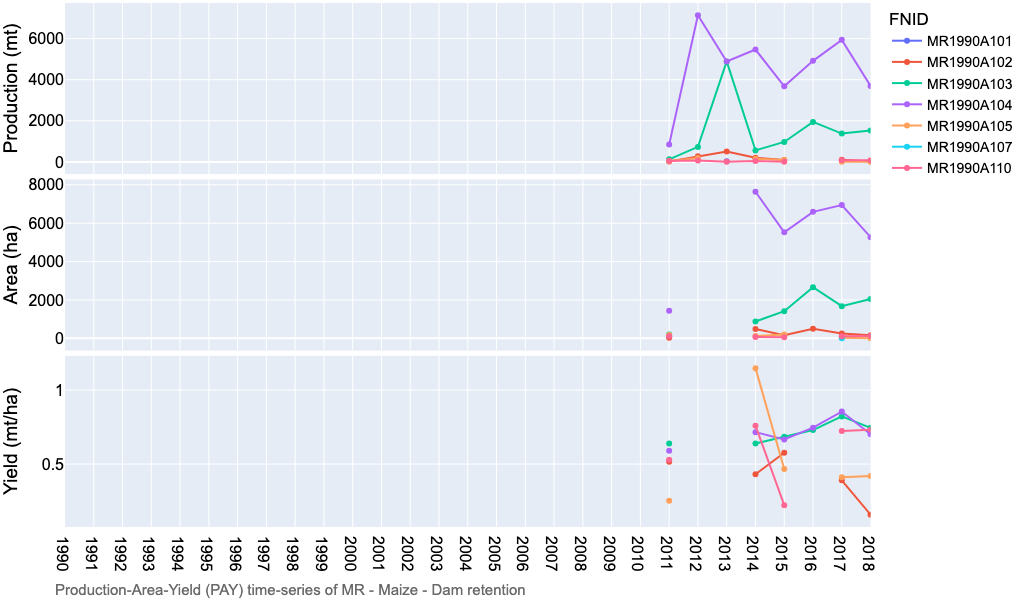

../figures/MR_line_pay_Maize_Walo.png is saved.


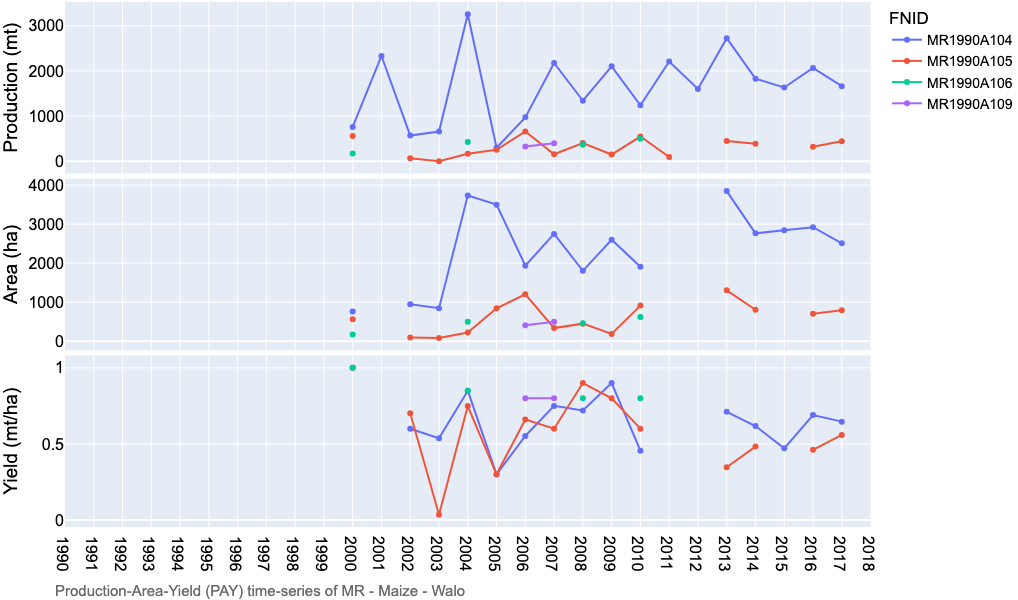

../figures/MR_line_pay_Millet_Annual.png is saved.


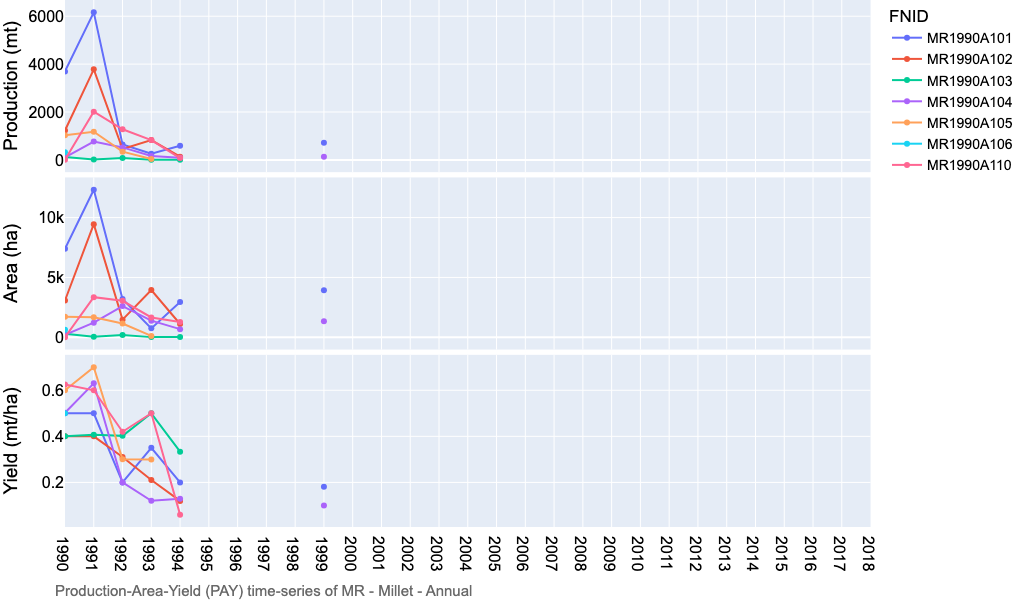

../figures/MR_line_pay_Millet_Main.png is saved.


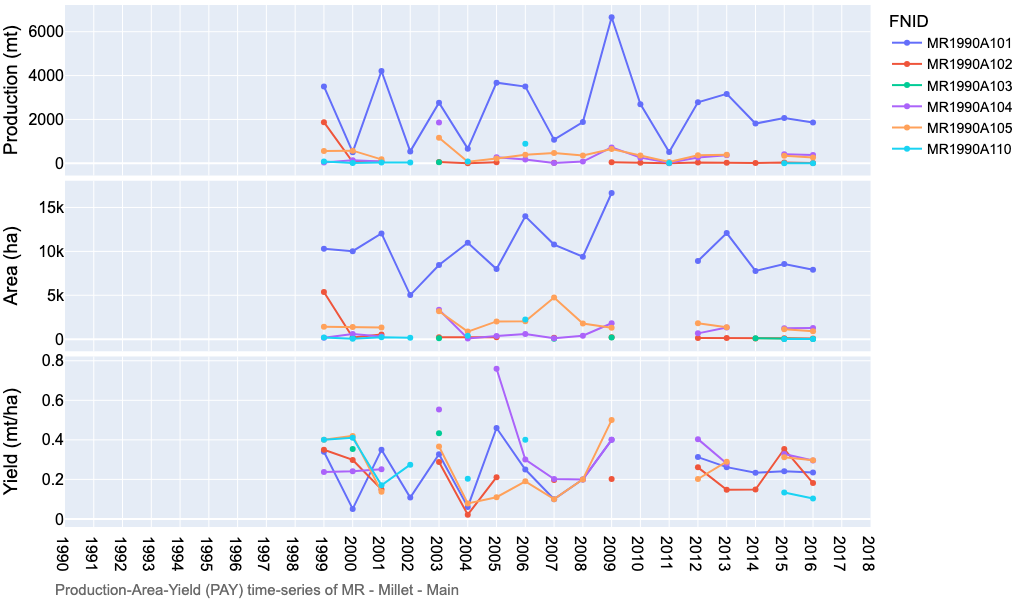

../figures/MR_line_pay_Rice_Walo.png is saved.


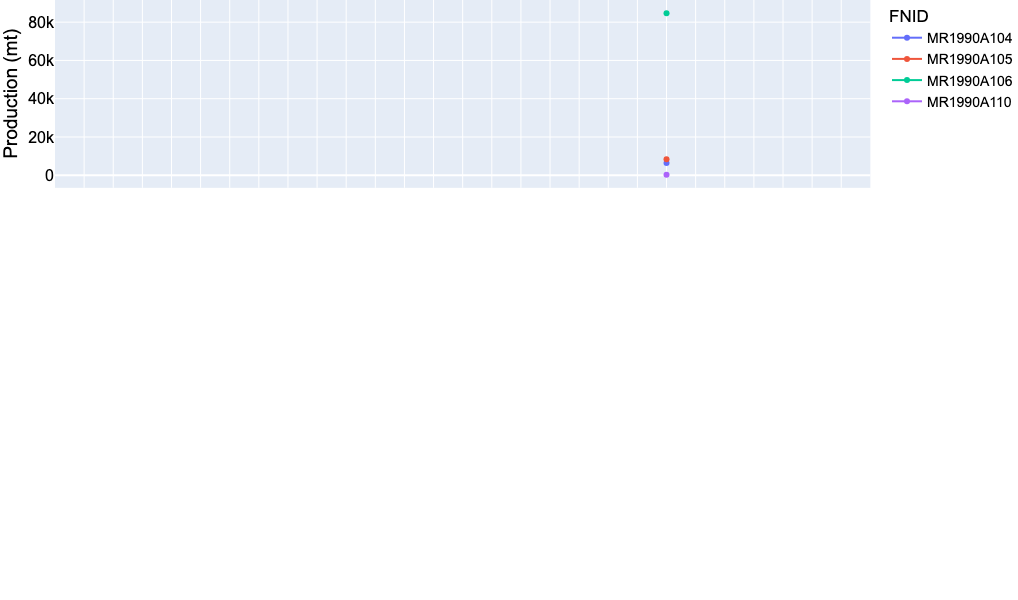

../figures/MR_line_pay_Rice_Main.png is saved.


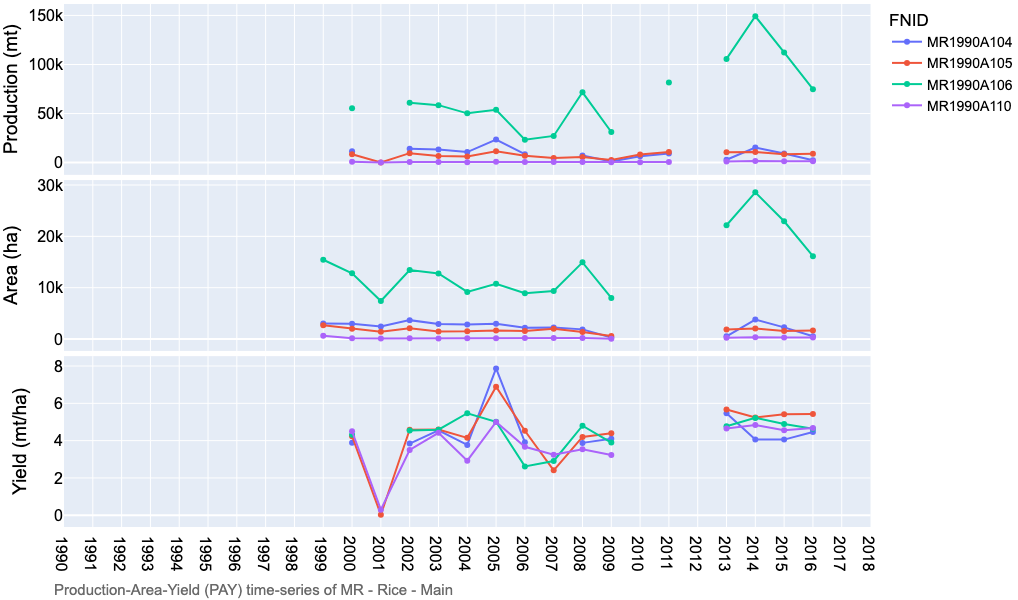

../figures/MR_line_pay_Rice_Bas-fond.png is saved.


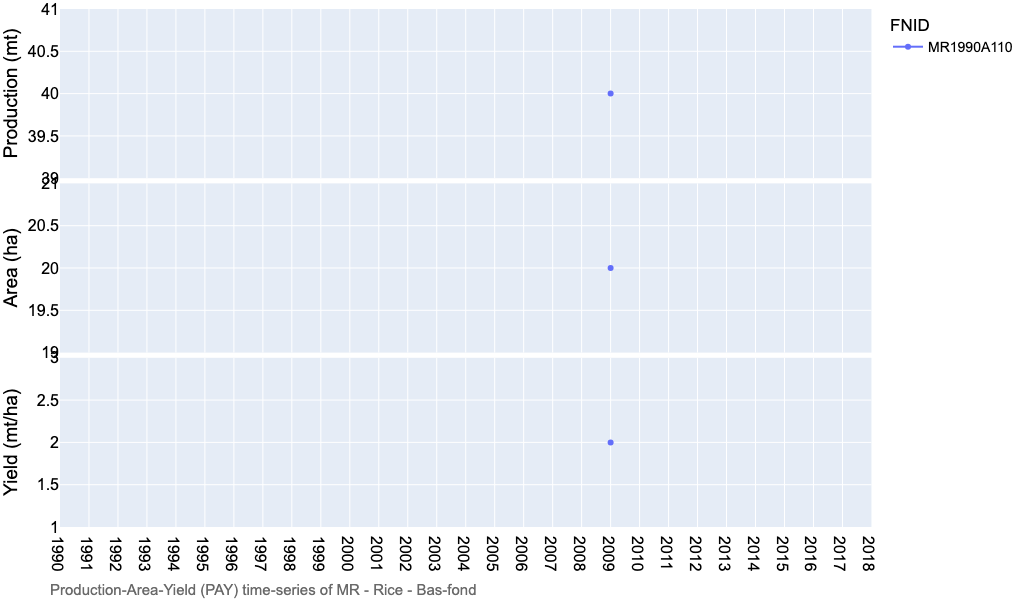

../figures/MR_line_pay_Rice_Dam retention.png is saved.


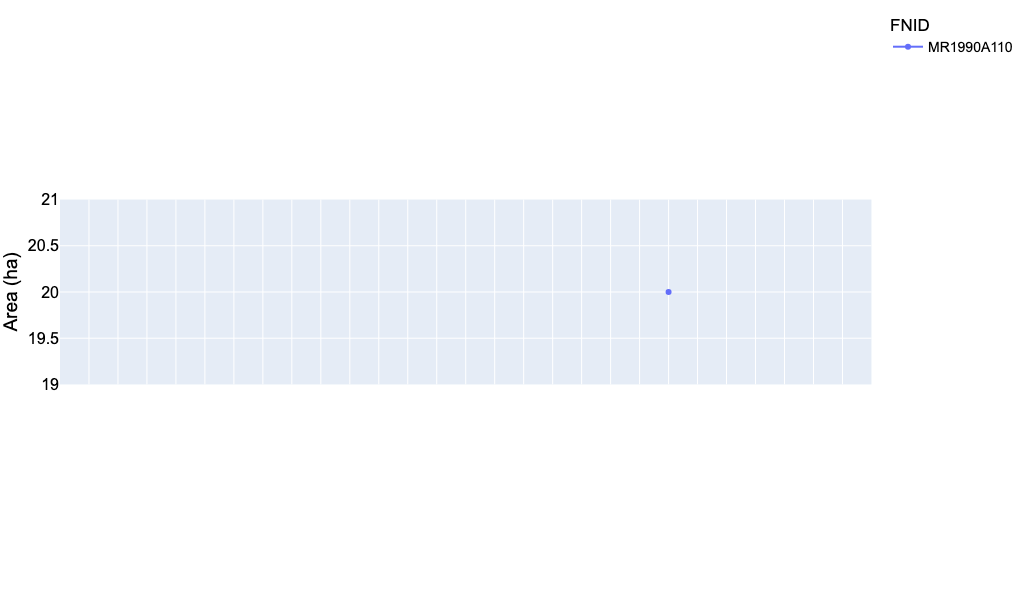

../figures/MR_line_pay_Rice_Hot off-season.png is saved.


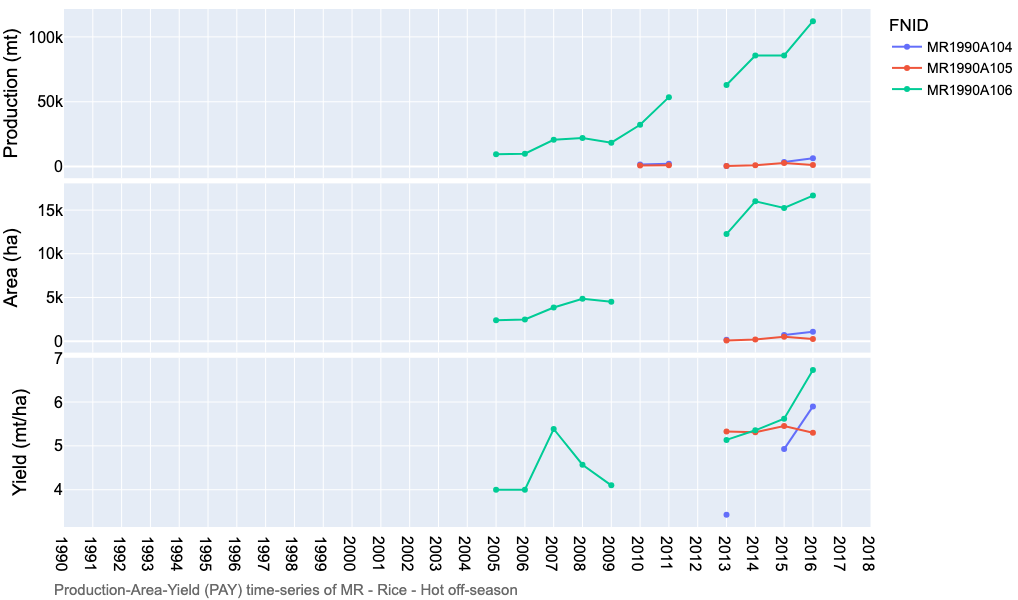

../figures/MR_line_pay_Sorghum_Walo.png is saved.


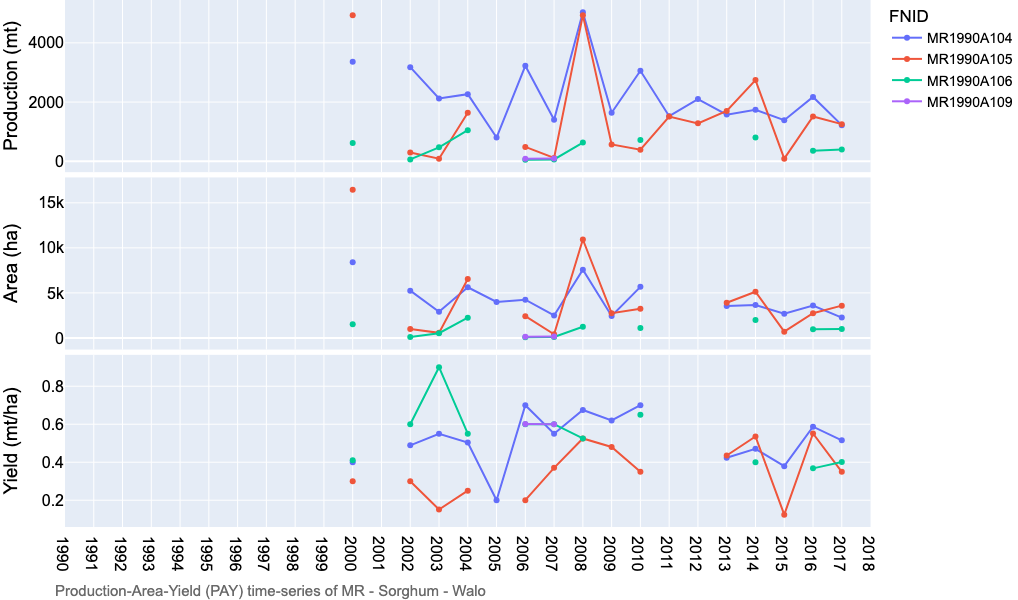

../figures/MR_line_pay_Sorghum_Main.png is saved.


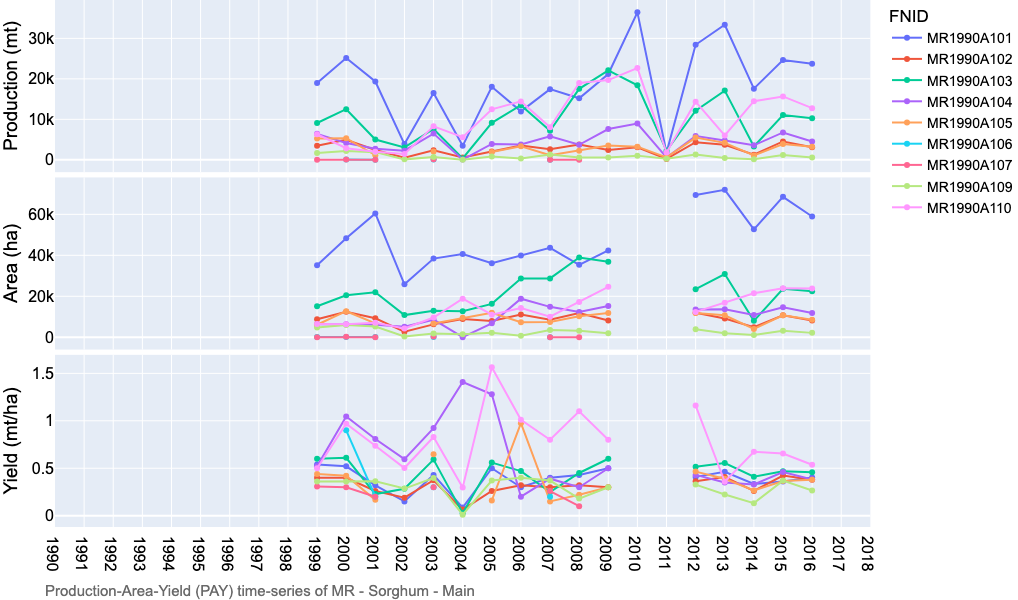

../figures/MR_line_pay_Sorghum_Bas-fond.png is saved.


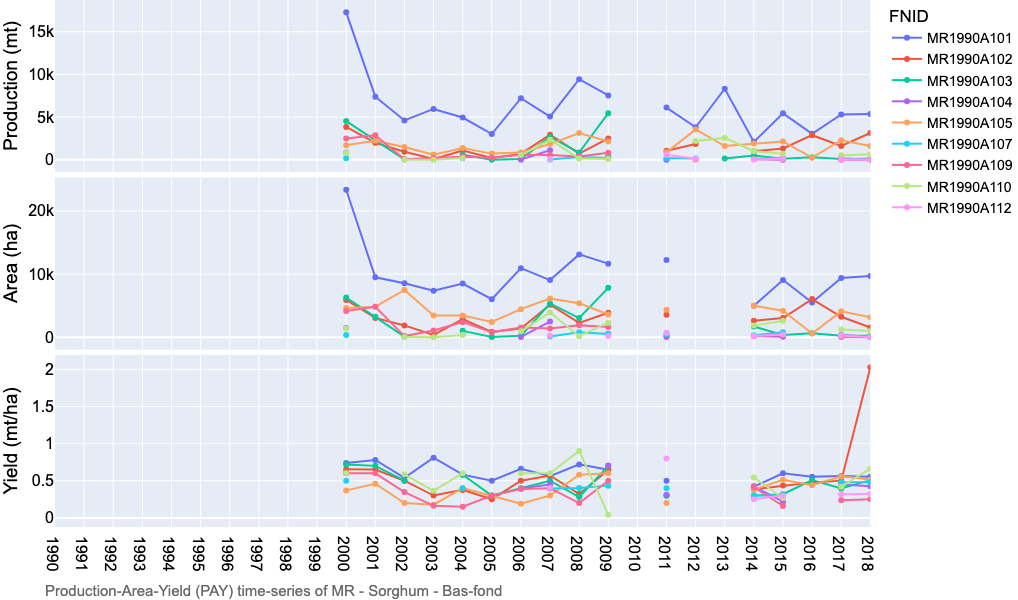

../figures/MR_line_pay_Sorghum_Dam retention.png is saved.


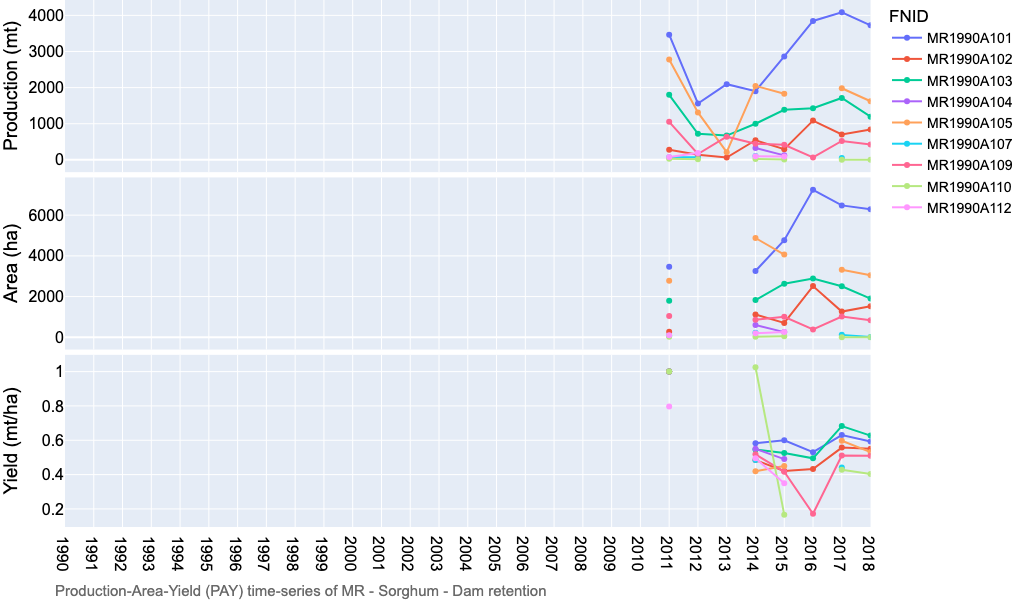

../figures/MR_line_pay_Sorghum_Annual.png is saved.


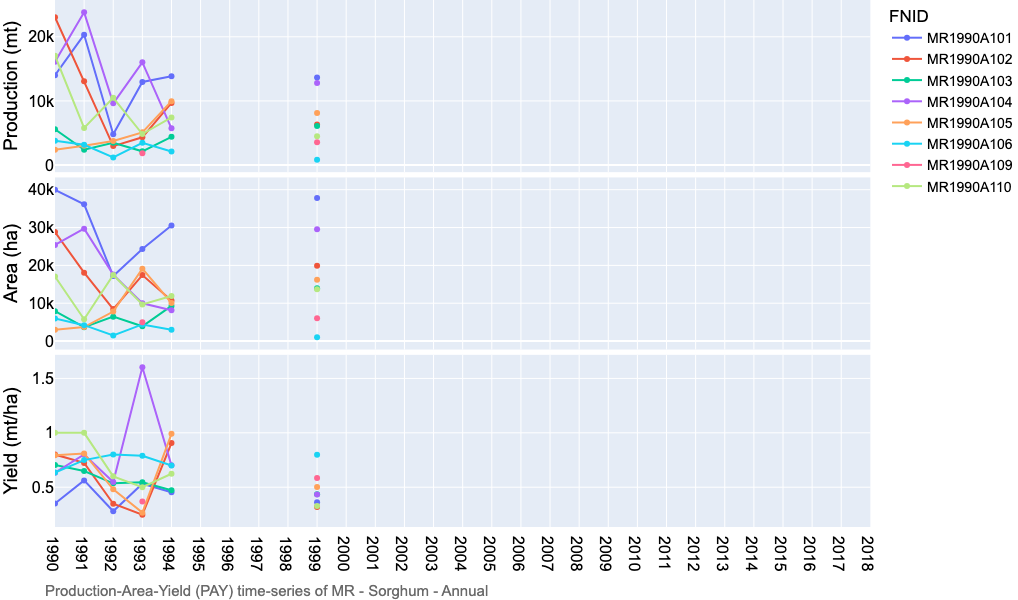

../figures/MR_line_pay_Wheat_Bas-fond.png is saved.


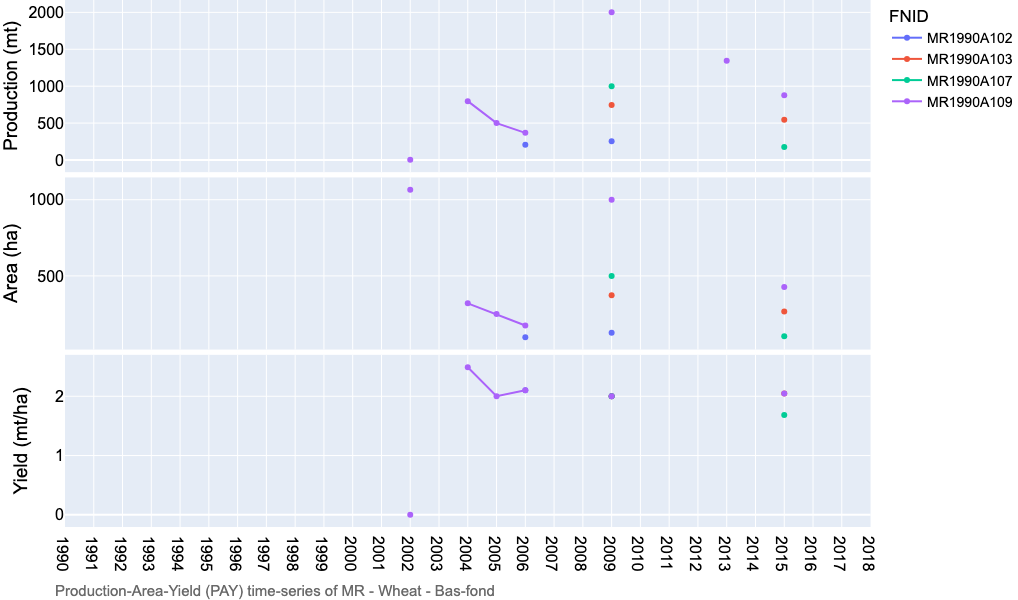

../figures/MR_line_pay_Wheat_Cold off-season.png is saved.


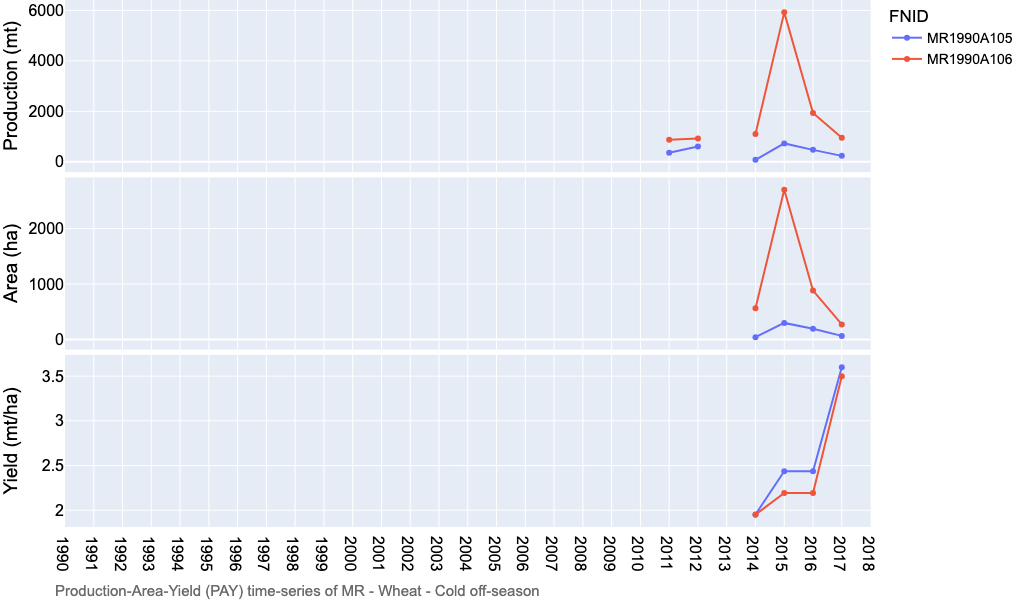

../figures/MR_line_pay_Wheat_Dam retention.png is saved.


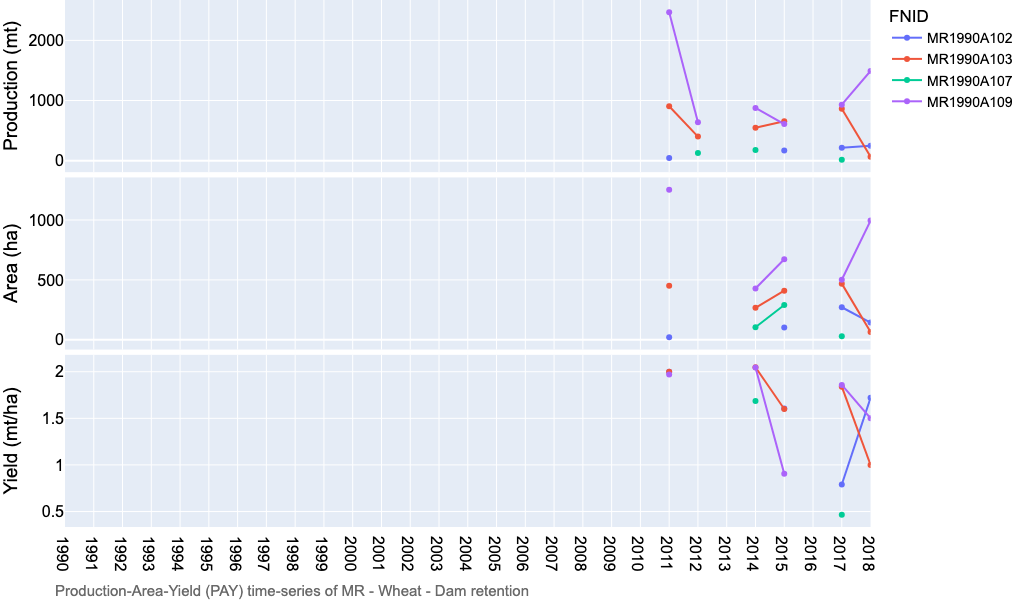

In [9]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'MR', 'Mauritania'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Main'],
    ['Maize','Annual'],
    ['Maize','Bas-fond'],
    ['Maize','Dam retention'],
    ['Maize', 'Walo'],
    ['Millet','Annual'],
    ['Millet','Main'],
    ['Rice','Walo'],
    ['Rice','Main'],
    ['Rice','Bas-fond'],
    ['Rice','Dam retention'],
    ['Rice','Hot off-season'],
    ['Sorghum','Walo'],
    ['Sorghum','Main'],
    ['Sorghum','Bas-fond'],
    ['Sorghum','Dam retention'],
    ['Sorghum','Annual'],
    ['Wheat','Bas-fond'],
    ['Wheat','Cold off-season'],
    ['Wheat','Dam retention']
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()

In [10]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'MR', 'Mauritania'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('../data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
prod_season = [
    ['Maize', 'Main'],
    ['Maize', 'Annual'],
    ['Maize', 'Bas-fond'],
    ['Maize', 'Dam retention'],
    ['Maize', 'Walo'],
    ['Millet', 'Annual'],
    ['Millet', 'Main'],
    ['Rice', 'Walo'],
    ['Rice', 'Main'],
    ['Rice', 'Bas-fond'],
    ['Rice', 'Dam retention'],
    ['Rice', 'Hot off-season '],
    ['Sorghum', 'Walo'],
    ['Sorghum', 'Main'],
    ['Sorghum', 'Bas-fond'],
    ['Sorghum', 'Dam retention'],
    ['Sorghum', 'Annual'],
    ['Wheat', 'Bas-fond'],
    ['Wheat', 'Cold off-season'],
    ['Wheat', 'Dam retention']
]
for product_name, season_name in prod_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = '../figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)



../figures/crop_calibrated/MR_Maize_Main_MR1990A101.png is saved.
../figures/crop_calibrated/MR_Maize_Main_MR1990A102.png is saved.
../figures/crop_calibrated/MR_Maize_Main_MR1990A103.png is saved.
../figures/crop_calibrated/MR_Maize_Main_MR1990A104.png is saved.
../figures/crop_calibrated/MR_Maize_Main_MR1990A105.png is saved.
../figures/crop_calibrated/MR_Maize_Main_MR1990A106.png is saved.
../figures/crop_calibrated/MR_Maize_Main_MR1990A110.png is saved.
../figures/crop_calibrated/MR_Maize_Annual_MR1990A101.png is saved.
../figures/crop_calibrated/MR_Maize_Annual_MR1990A102.png is saved.
../figures/crop_calibrated/MR_Maize_Annual_MR1990A103.png is saved.
../figures/crop_calibrated/MR_Maize_Annual_MR1990A104.png is saved.
../figures/crop_calibrated/MR_Maize_Annual_MR1990A105.png is saved.
../figures/crop_calibrated/MR_Maize_Annual_MR1990A106.png is saved.
../figures/crop_calibrated/MR_Maize_Annual_MR1990A110.png is saved.
../figures/crop_calibrated/MR_Maize_Bas-fond_MR1990A101.png is